# Block Resampling & Z Scores

### To Do List

1. Produce multiple random series
2. Try with more input data (more years) 
3. Generate extreme indices for seasons (warm season, cool season, wet season, dry season)
4. Generate new sequence based on multiple warm years, cool years, wet years, dry years etc. 

### User-Defined Variables

In [1]:
startyear = 2008 #first year of your weather data
endyear = 2014 #second year of your weather data
outputyears = 50 #number of years in your generated sequence

### Load Necessary Packages

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Read in & display climate data

In [3]:
df = pd.read_csv("E:\PhD\Data\MetData\Oak Park\dly375.csv", na_values=[' '])

### Create mean temp field

In [4]:
df['Tmean'] = (df['Tmin'] + df['Tmax']) / 2
df.Tmean = df.Tmean.round(1) #keep Tmean to one decimal place as that's what's in the original data

### Filter out unnecessary columns

In [5]:
df = df[['date','Tmean','PEHargreaves','rain']]
df.head()

,date,Tmean,PEHargreaves,rain
0,01-Jan-07,4.8,0.204550,4.8
1,02-Jan-07,7.1,0.307591,0.4
2,03-Jan-07,10.1,0.324289,2.9
3,04-Jan-07,8.5,0.239071,0.0
4,05-Jan-07,7.4,0.351019,0.8


### Convert 'date' column to datetime object so Pandas can use it 

In [6]:
df['date'] = pd.to_datetime(df['date'], format= '%d-%b-%y') # https://docs.python.org/2/library/datetime.html see end of this page for %d %m %Y

### Split data into seasons based on months

Spring = 1, Summer = 2, Autumn = 3, Winter = 4

In [7]:
#create a season function to split data into seasons
def get_season(row):
    if row['date'].month >= 3 and row['date'].month <= 5:
        return '1'
    elif row['date'].month >= 6 and row['date'].month <= 8:
        return '2'
    elif row['date'].month >= 9 and row['date'].month <= 11:
        return '3'
    else:
        return '4'

### Apply the season function to the data

In [8]:
df['Season'] = df.apply(get_season, axis=1)

### Create 'Year' column from the 'date' column

In [9]:
df['Year'] = df['date'].dt.year

### Make December of previous year part of winter for current year

In [10]:
#Redefine the year to attach December of previous year to winter of following year 
#Everywhere the month is '12', the year column gets increased by 1. 
df.loc[df['date'].dt.month == 12, 'Year'] += 1

### Create a new dataframe indexed by Year and Season

In [11]:
#how to multiindex from here: http://stackoverflow.com/questions/33435971/selecting-time-series-data-in-a-specific-sequence-using-pandas/33437422#33437422
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2.head()

date  Tmean  PEHargreaves  rain
Year Season                                      
2007 4      2007-01-01    4.8      0.204550   4.8
     4      2007-01-02    7.1      0.307591   0.4
     4      2007-01-03   10.1      0.324289   2.9
     4      2007-01-04    8.5      0.239071   0.0
     4      2007-01-05    7.4      0.351019   0.8

### Calculate mean values for each season

In [12]:
seasmean = df['Tmean'].groupby(df['Season']).mean()
sprmean = seasmean['1']
summean = seasmean['2']
autmean = seasmean['3']
winmean = seasmean['4']
print sprmean
print summean
print autmean
print winmean

8.84541062802
14.8590452261
10.4568681319
4.90742637644


### Calculating differences between season and season means

In [13]:
seasdif = df2['Tmean'].groupby(level=['Year','Season']).mean() - seasmean
seasdif

Year  Season
2007  1         0.883937
      2        -0.128610
      3         0.518956
      4         1.368845
2008  1         0.016546
      2        -0.091654
      3        -0.922802
      4         1.187079
2009  1         0.174155
      2         0.112694
      3         0.176099
      4        -0.560760
2010  1        -0.442150
      2         0.427911
      3        -0.790934
      4        -2.502982
2011  1         0.729589
      2        -1.171133
      3         1.362912
      4        -1.867426
2012  1        -0.054106
      2        -0.253610
      3        -1.273352
      4         1.523343
2013  1        -1.618237
      2         1.223563
      3         0.406868
      4         0.202574
2014  1         0.794807
      2         0.447477
      3         0.522253
      4         1.017018
2015  1        -0.484541
      2        -0.873799
      3              NaN
      4         0.073685
Name: Tmean, dtype: float64

### Visualise these seasonal differences

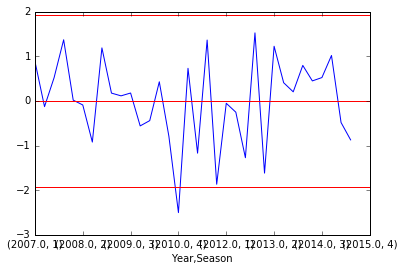

In [14]:
#visualise the seasonal differences (calculate greater than 2 standard deviations?)
seasdif.plot()
plt.axhline(0,color='red')
plt.axhline(seasdif.std() * 2, color ='red')
plt.axhline(-(seasdif.std()) * 2, color ='red')

# Extracting extreme seasons

### Create a copy of the dataframe and two blank lists for hot and cold extremes

In [15]:
seasdif2 = pd.DataFrame(seasdif)
warm = []
cold = []

### Create a function which identifies warm and cold extremes based on the data

In [16]:
def extremeseas(seasdif):
    for season in seasdif:
        if season > seasdif.std() * 2:
            warm.append(1)
        else:
            warm.append(0)

    for season in seasdif:
        if season < (-(seasdif.std()*2)):
            cold.append(1)
        else:
            cold.append(0)

### Apply the function to the dataset

In [17]:
extremeseas(seasdif)

### Create new columns in duplicate dataset to identify which season has an extreme value

In [18]:
seasdif2['cold']=cold
seasdif2['warm']=warm
seasdif2

Tmean  cold  warm
Year Season                      
2007 1       0.883937     0     0
     2      -0.128610     0     0
     3       0.518956     0     0
     4       1.368845     0     0
2008 1       0.016546     0     0
     2      -0.091654     0     0
     3      -0.922802     0     0
     4       1.187079     0     0
2009 1       0.174155     0     0
     2       0.112694     0     0
     3       0.176099     0     0
     4      -0.560760     0     0
2010 1      -0.442150     0     0
     2       0.427911     0     0
     3      -0.790934     0     0
     4      -2.502982     1     0
2011 1       0.729589     0     0
     2      -1.171133     0     0
     3       1.362912     0     0
     4      -1.867426     0     0
2012 1      -0.054106     0     0
     2      -0.253610     0     0
     3      -1.273352     0     0
     4       1.523343     0     0
2013 1      -1.618237     0     0
     2       1.223563     0     0
     3       0.406868     0     0
     4       0.202574     0     0
2014 1       0.794807     0     0
     2       0.447477     0     0
     3       0.522253     0     0
     4       1.017018     0     0
2015 1      -0.484541     0     0
     2      -0.873799     0     0
     3            NaN     0     0
     4       0.073685     0     0

# Create a new dataframe with random seasons and extreme seasons

In [19]:
#identify columns with cold extremes (could do the same for warm but there are none)
seasdif2[seasdif2.cold == 1] 

,,Tmean,cold,warm
Year,Season,,,
2010,4,-2.502982,1,0


In [20]:
#blank dataframe
future = pd.DataFrame()

### Loop through for x amount of years

In [21]:
for i in range(outputyears):
    for season in ['1', '2', '3', '4']:
        future = future.append(df2.loc[np.random.choice(range(startyear, endyear))]
                                  .loc[season])


In [22]:
future.head()

,date,Tmean,PEHargreaves,rain
Season,,,,
1,2013-03-01,4.9,1.054200,0
1,2013-03-02,3.7,1.001356,0
1,2013-03-03,2.3,1.012771,0
1,2013-03-04,2.5,0.766577,0
1,2013-03-05,4.1,1.336756,0


### Change the output directory and save the file

In [16]:
#check spacing replace with underscore
os.chdir('E:\PhD\Data\Block Resampling')
#save the file
empty.to_csv('empty.csv', sep = ',')

# The following calculates z-scores, and doesn't make much sense...

In [104]:
#zscore calculation 
df.dtypes #check column datatypes
df.head() #view header
cols = list(df.columns) #convert to list
cols.remove('date')
cols.remove('Season')
cols.remove('Year') #remove unnecessary columns
df[cols]

for col in cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    
#minus the season mean and divide by the stddev of the seasmean

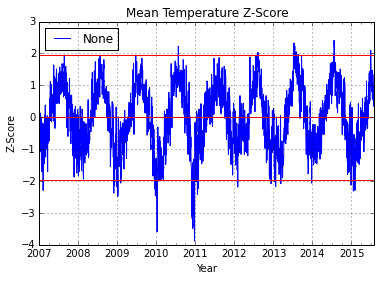

In [105]:
#plotting z scores
df.plot(x='date',y='Tmean_zscore')    
plt.axhline(0, color='red')  
plt.axhline(0, color='red')
plt.axhline(1.96, color='red')
plt.axhline(-1.96, color='red')
plt.title('Mean Temperature Z-Score')
plt.xlabel('Year')
plt.ylabel('Z-Score')
plt.savefig('temp z score.png', dpi = 500)

### Calculate 'extremes' based on z-scores greater than 2 or less than -2

In [106]:
extremes = df[(df['Tmean_zscore'] >=2) | (df['Tmean_zscore'] <= -2)]
extremes

,date,Tmean,PEHargreaves,rain,Season,Year,Tmean_zscore,PEHargreaves_zscore,rain_zscore
37,2007-02-07,-1.2,0.520341,4.9,4,2007,-2.294063,-0.998568,0.536216
698,2008-11-29,-1.6,0.222306,0.0,3,2008,-2.377742,-1.226774,-0.511918
705,2008-12-06,-0.4,0.251114,0.0,4,2009,-2.126706,-1.204716,-0.511918
726,2008-12-27,-0.4,0.266684,0.0,4,2009,-2.126706,-1.192794,-0.511918
728,2008-12-29,-0.7,0.266254,0.0,4,2009,-2.189465,-1.193123,-0.511918
735,2009-01-05,-0.2,0.312983,0.0,4,2009,-2.084867,-1.157343,-0.511918
736,2009-01-06,-2.1,0.259337,0.0,4,2009,-2.482340,-1.198420,-0.511918
737,2009-01-07,-1.8,0.310206,0.0,4,2009,-2.419581,-1.159469,-0.511918
738,2009-01-08,-0.4,0.347391,0.0,4,2009,-2.126706,-1.130997,-0.511918
763,2009-02-02,-0.1,0.274983,6.6,4,2009,-2.063947,-1.186439,0.899855


In [107]:
#figure out how to select 'normal' seasons and follow with 'extreme' seasons. 